In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import splitfolders
import tensorflow as tf
import os
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-03-28 14:54:06.479667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 14:54:06.479786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 14:54:06.612533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_path = "/kaggle/input/abdallahodeh/new_dataset/Gano-Cat-Breeds-V1_1"

splitfolders.ratio(dataset_path, ratio=(0.85, 0.15), group_prefix=True)


Copying files: 6375 files [01:19, 80.37 files/s] 


In [4]:
train_path = '/kaggle/working/output/train'
val_path = '/kaggle/working/output/val'
test_path = '/kaggle/working/output/test'

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255.0)

# Create train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 5415 images belonging to 15 classes.
Found 960 images belonging to 15 classes.


In [6]:
from tensorflow.keras.applications import Xception
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)


base_model = Xception(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze initial layers of the base model
for layer in base_model.layers[:25]:
    layer.trainable = True

# Add custom head layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  
x = Dropout(0.4)(x)  
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  
predictions = Dense(15, activation='softmax')(x)

# Combine base model and custom head
model_Xception_Adam = Model(inputs=base_model.input, outputs=predictions)

model_Xception_Adam.compile(optimizer=Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_Xception_Adam = model_Xception_Adam.fit(train_generator, epochs=10,
                    validation_data=validation_generator, callbacks=[reduce_lr, early_stopping])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-28 14:56:58.053587: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[728,728,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,728,28,28]{3,2,1,0}, f32[64,728,28,28]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-28 14:56:58.072811: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.019353387s
Trying algorithm eng0{} for conv (f32[728,728,1,1]{3,2

55/85 ━━━━━━━━━━━━━━━━━━━━ 27s 905ms/step - accuracy: 0.1637 - loss: 2.9073

W0000 00:00:1711637940.045010     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2194 - loss: 2.6817

W0000 00:00:1711637967.063782     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.2211 - loss: 2.6751 - val_accuracy: 0.6260 - val_loss: 1.3909 - learning_rate: 1.0000e-04
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 87s 945ms/step - accuracy: 0.6222 - loss: 1.2006 - val_accuracy: 0.7344 - val_loss: 0.8711 - learning_rate: 1.0000e-04
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 86s 932ms/step - accuracy: 0.7119 - loss: 0.8796 - val_accuracy: 0.7656 - val_loss: 0.7178 - learning_rate: 1.0000e-04
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 87s 943ms/step - accuracy: 0.7592 - loss: 0.7198 - val_accuracy: 0.8042 - val_loss: 0.6230 - learning_rate: 1.0000e-04
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 89s 963ms/step - accuracy: 0.7872 - loss: 0.6274 - val_accuracy: 0.8115 - val_loss: 0.6038 - learning_rate: 1.0000e-04
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 88s 955ms/step - accuracy: 0.8383 - loss: 0.5121 - val_accuracy: 0.8208 - val_loss: 0.5382 - learning_rate: 1.0000e-04
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 86s 934ms/step - accuracy: 0.8386

In [7]:
test_path = '/kaggle/input/newnew/cat dataset'
test_datagen = ImageDataGenerator(rescale=1./255)  
test_generator = test_datagen.flow_from_directory (
    test_path,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical', 
    shuffle=False
)

# Evaluate the model on the test data
loss, accuracy = model_Xception_Adam.evaluate(test_generator, verbose=1)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Found 519 images belonging to 15 classes.
1/9 ━━━━━━━━━━━━━━━━━━━━ 7s 887ms/step - accuracy: 0.6094 - loss: 1.9073

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7695 - loss: 0.9412
Test Loss: 0.5578327178955078
Test Accuracy: 0.8381502628326416


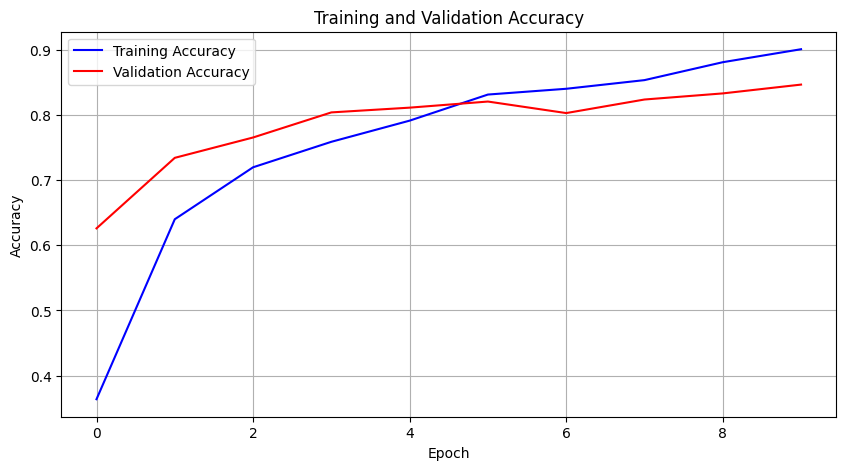

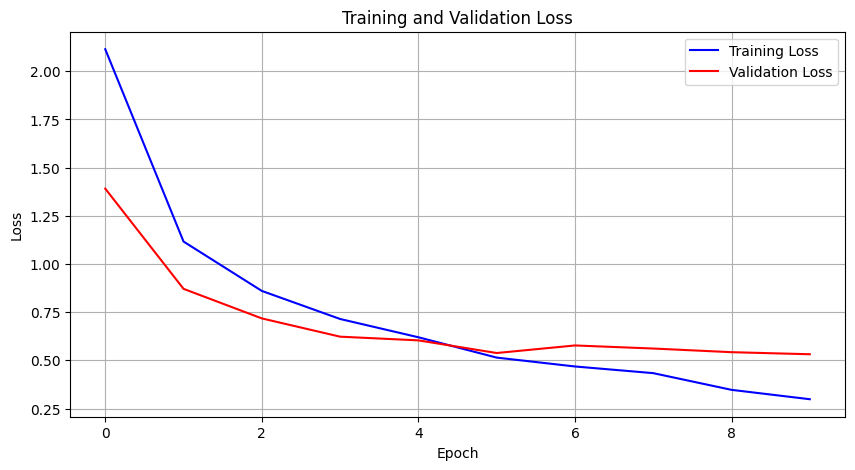

In [14]:
import matplotlib.pyplot as plt

# Get training and validation accuracy
train_accuracy = history_Xception_Adam.history['accuracy']
val_accuracy = history_Xception_Adam.history['val_accuracy']

# Get training and validation loss
train_loss = history_Xception_Adam.history['loss']
val_loss = history_Xception_Adam.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


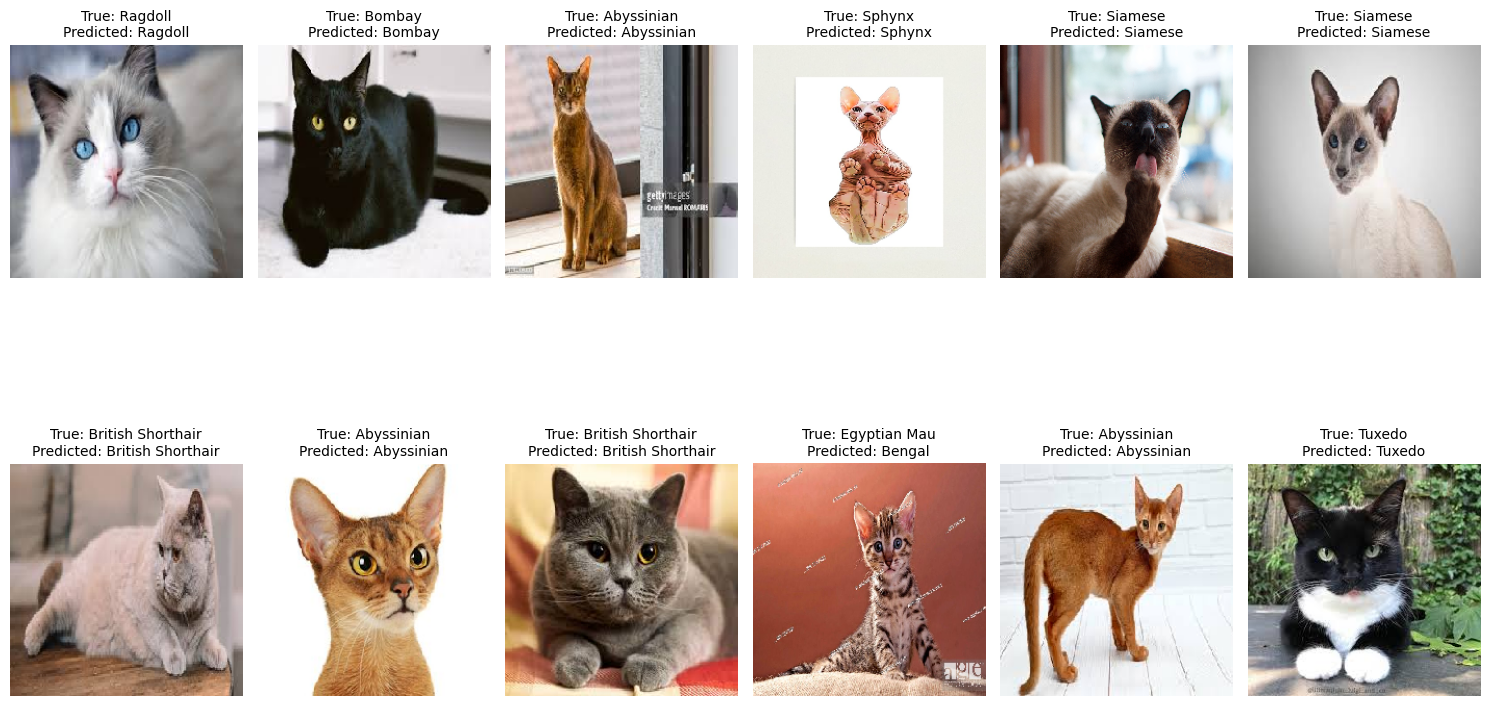

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sample_images(test_generator, model, sample_size=10):
    class_names = list(test_generator.class_indices.keys())
    num_batches = len(test_generator)
    sample_indices = np.random.choice(num_batches * test_generator.batch_size, size=sample_size, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(sample_indices, start=1):
        batch_index = idx // test_generator.batch_size
        index_in_batch = idx % test_generator.batch_size
        
        # Extract the batch containing the sample
        x_batch, y_batch = test_generator[batch_index]
        
        # Extract the sample from the batch
        x_sample = x_batch[index_in_batch]
        y_sample = y_batch[index_in_batch]
        
        plt.subplot(2, (sample_size + 1) // 2, i)  
        plt.imshow(x_sample)  
        plt.axis('off')
        
        true_label = np.argmax(y_sample)  # Convert one-hot encoded label to integer
        predicted_label = np.argmax(model.predict(np.expand_dims(x_sample, axis=0)))  # Predict the label for the sample
        true_label = class_names[true_label]
        predicted_label = class_names[predicted_label]
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=10)
    plt.tight_layout()
    plt.show()

# Usage example:
plot_sample_images(test_generator, model_Xception_Adam, sample_size=12)


In [23]:
model_Xception_Adam.save("model_Xception_Adam.h5")